In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import random

In [3]:
(X_train1, y_train1), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train1 = X_train1.astype('float32')
X_test = X_test.astype('float32')

In [4]:
epochs = 10
batch_size = 16
margin = 1

Define training and validation sets

In [5]:
X_train, X_val = X_train1[:30000], X_train1[30000:]
y_train, y_val = y_train1[:30000], y_train1[30000:]
del X_train1, y_train1

Create a pair of images

In [6]:
def make_pairs(x, y):

  num_classes = max(y) + 1
  digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

  pairs = []
  labels = []

  for idx1 in range(len(x)):

    x1 = x[idx1]
    label1 = y[idx1]
    idx2 = random.choice(digit_indices[label1])
    x2 = x[idx2]

    pairs+= [[x1,x2]]
    labels += [1]

    label2 = random.randint(0, num_classes -1)
    while label2 == label1:
      label2 = random.randint(0, num_classes -1)

    idx2 = random.choice(digit_indices[label2])
    x2 = x[idx2]

    pairs += [[x1,x2]]
    labels += [1]

  return np.array(pairs), np.array(labels).astype('float32')

pairs_train, labels_train = make_pairs(X_train, y_train)

pairs_val, labels_val = make_pairs(X_val, y_val)

pairs_test, labels_test = make_pairs(X_test, y_test)


In [7]:
X_train1 = pairs_train[:, 0]
X_train2 = pairs_train[:,1]

In [8]:
X_val1 = pairs_val[:,0]
X_val2 = pairs_val[:,1]

In [9]:
X_test1 = pairs_test[:,0]
X_test2 = pairs_test[:,1]

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize(pairs, labels, to_show=5, num_col=1, predictions=None, test=False):
    num_row = (to_show + num_col - 1) // num_col  # Calculate number of rows
    to_show = min(to_show, len(pairs))  # Ensure to_show doesn't exceed number of pairs

    fig, axes = plt.subplots(num_row, num_col, figsize=(5*num_col, 5*num_row))

    # Flatten axes array if only one column is used
    if num_col == 1:
        axes = axes.reshape(-1)

    for i in range(to_show):
        ax = axes[i]

        pair_image = tf.concat([pairs[i][0], pairs[i][1]], axis=1)
        ax.imshow(pair_image, cmap='gray')
        ax.set_axis_off()

        if test and predictions is not None:
            ax.set_title('True:{} | Pred:{:.3f}'.format(labels[i], predictions[i][0]))
        else:
            ax.set_title('label : {}'.format(labels[i]))

    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))

    plt.show()

# Example usage:
# visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=1)


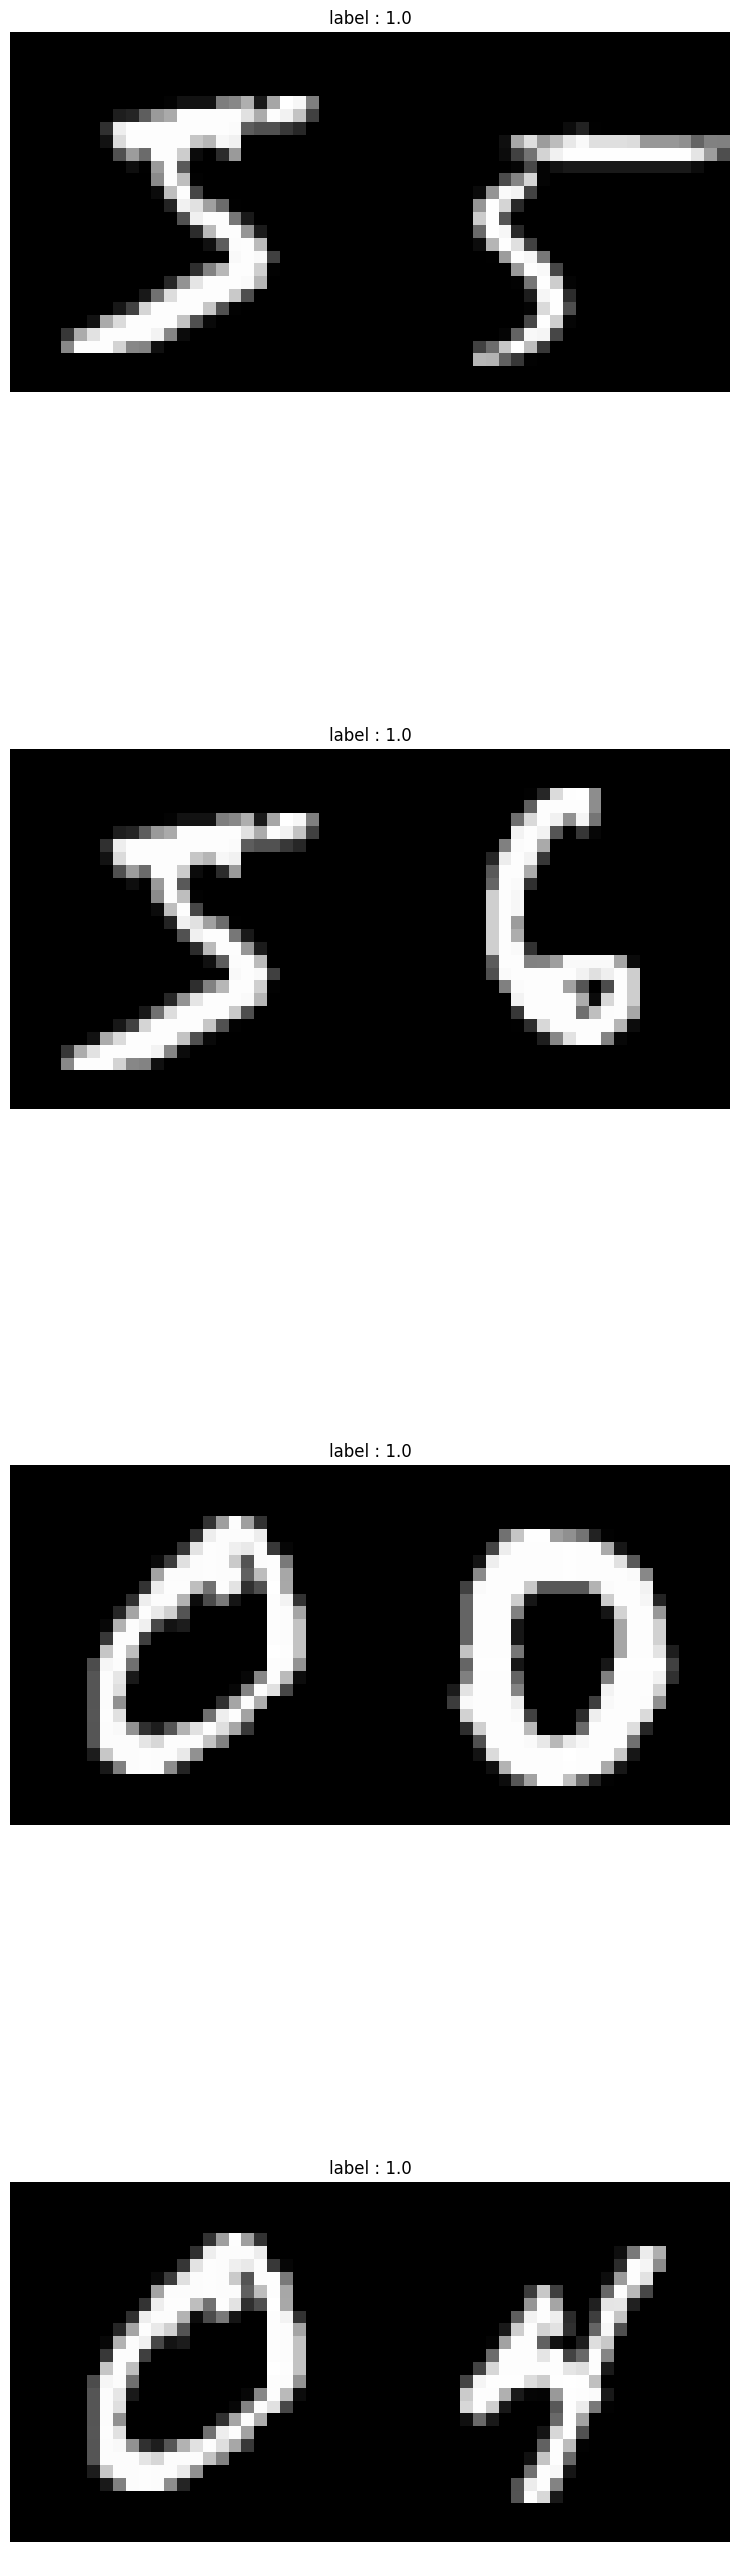

In [11]:
visualize(pairs_train[:-1], labels_train[:-1], to_show =4, num_col=1)

Define the model

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.backend import epsilon

def euclidean_distance(vects):
    x, y = vects
    num_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(num_square, epsilon()))


input = layers.Input((28,28,1))
x = tf.keras.layers.BatchNormalization()(input)
x= layers.Conv2D(4, (5,5), activation = 'tanh')(x)
x = AveragePooling2D(pool_size =(2,2))(x)

x= layers.Conv2D(4, (5,5), activation = 'tanh')(x)
x = AveragePooling2D(pool_size =(2,2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation = 'tanh')(x)

embedding_network = keras.Model(input, x)


input_1= layers.Input((28,28,1))
input_2= layers.Input((28,28,1))

tower1 = embedding_network(input_1)
tower2 =  embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower1, tower2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation = "sigmoid")(normal_layer)
sisamese = keras.Model(inputs = [input_1, input_2], outputs = output_layer)

define the constrastive loss and Train

In [14]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(y_true * margin_square + (1 - y_true) * square_pred)
    return contrastive_loss


# Specify margin hyperparameter for contrastive loss
margin = 1.0

# Compile the model with custom contrastive loss and optimizer
sisamese.compile(loss=contrastive_loss_with_margin(margin),
                optimizer='rmsprop',  # Corrected optimizer name
                metrics=['accuracy'])

# Display model summary
sisamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 model (Functional)          (None, 10)                   1418      ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['model[0][0]',         

Train the model

In [15]:
history = sisamese.fit(
    [X_train1, X_train2],
    labels_train,
    validation_data = ([X_val1, X_val2],labels_val ),
    batch_size =batch_size ,
    epochs = 10
)

Epoch 1/10
3750/3750 [==============================] - 42s 8ms/step - loss: 0.0292 - accuracy: 0.9733 - val_loss: 4.1779e-06 - val_accuracy: 1.0000
Epoch 2/10
3750/3750 [==============================] - 28s 8ms/step - loss: 2.2862e-06 - accuracy: 1.0000 - val_loss: 1.3619e-06 - val_accuracy: 1.0000
Epoch 3/10
3750/3750 [==============================] - 29s 8ms/step - loss: 1.0283e-06 - accuracy: 1.0000 - val_loss: 7.9226e-07 - val_accuracy: 1.0000
Epoch 4/10
3750/3750 [==============================] - 30s 8ms/step - loss: 6.5876e-07 - accuracy: 1.0000 - val_loss: 5.5273e-07 - val_accuracy: 1.0000
Epoch 5/10
3750/3750 [==============================] - 31s 8ms/step - loss: 4.8170e-07 - accuracy: 1.0000 - val_loss: 4.2201e-07 - val_accuracy: 1.0000
Epoch 6/10
3750/3750 [==============================] - 29s 8ms/step - loss: 3.7816e-07 - accuracy: 1.0000 - val_loss: 3.3994e-07 - val_accuracy: 1.0000
Epoch 7/10
3750/3750 [==============================] - 31s 8ms/step - loss: 3.1041e-0

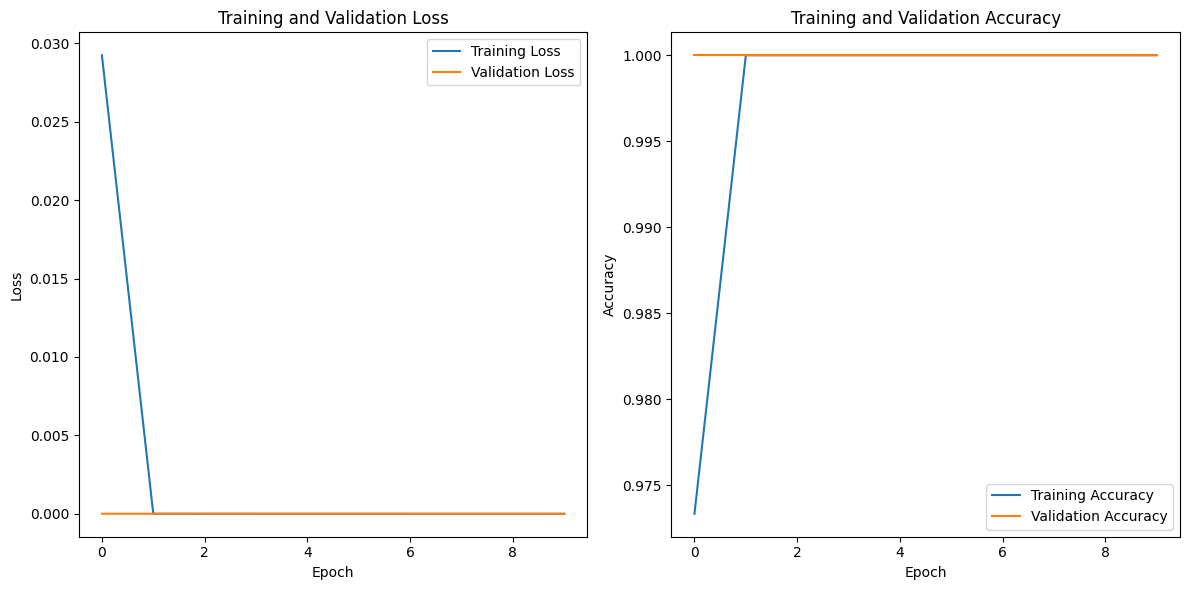

In [19]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Evaluate the model

In [20]:
results = sisamese.evaluate([X_test1, X_test2], labels_test)
print("test loss, test acc:", results)

625/625 [==============================] - 2s 3ms/step - loss: 1.8865e-07 - accuracy: 1.0000
test loss, test acc: [1.8865092954456486e-07, 1.0]


Visualize the prediction

625/625 [==============================] - 1s 2ms/step


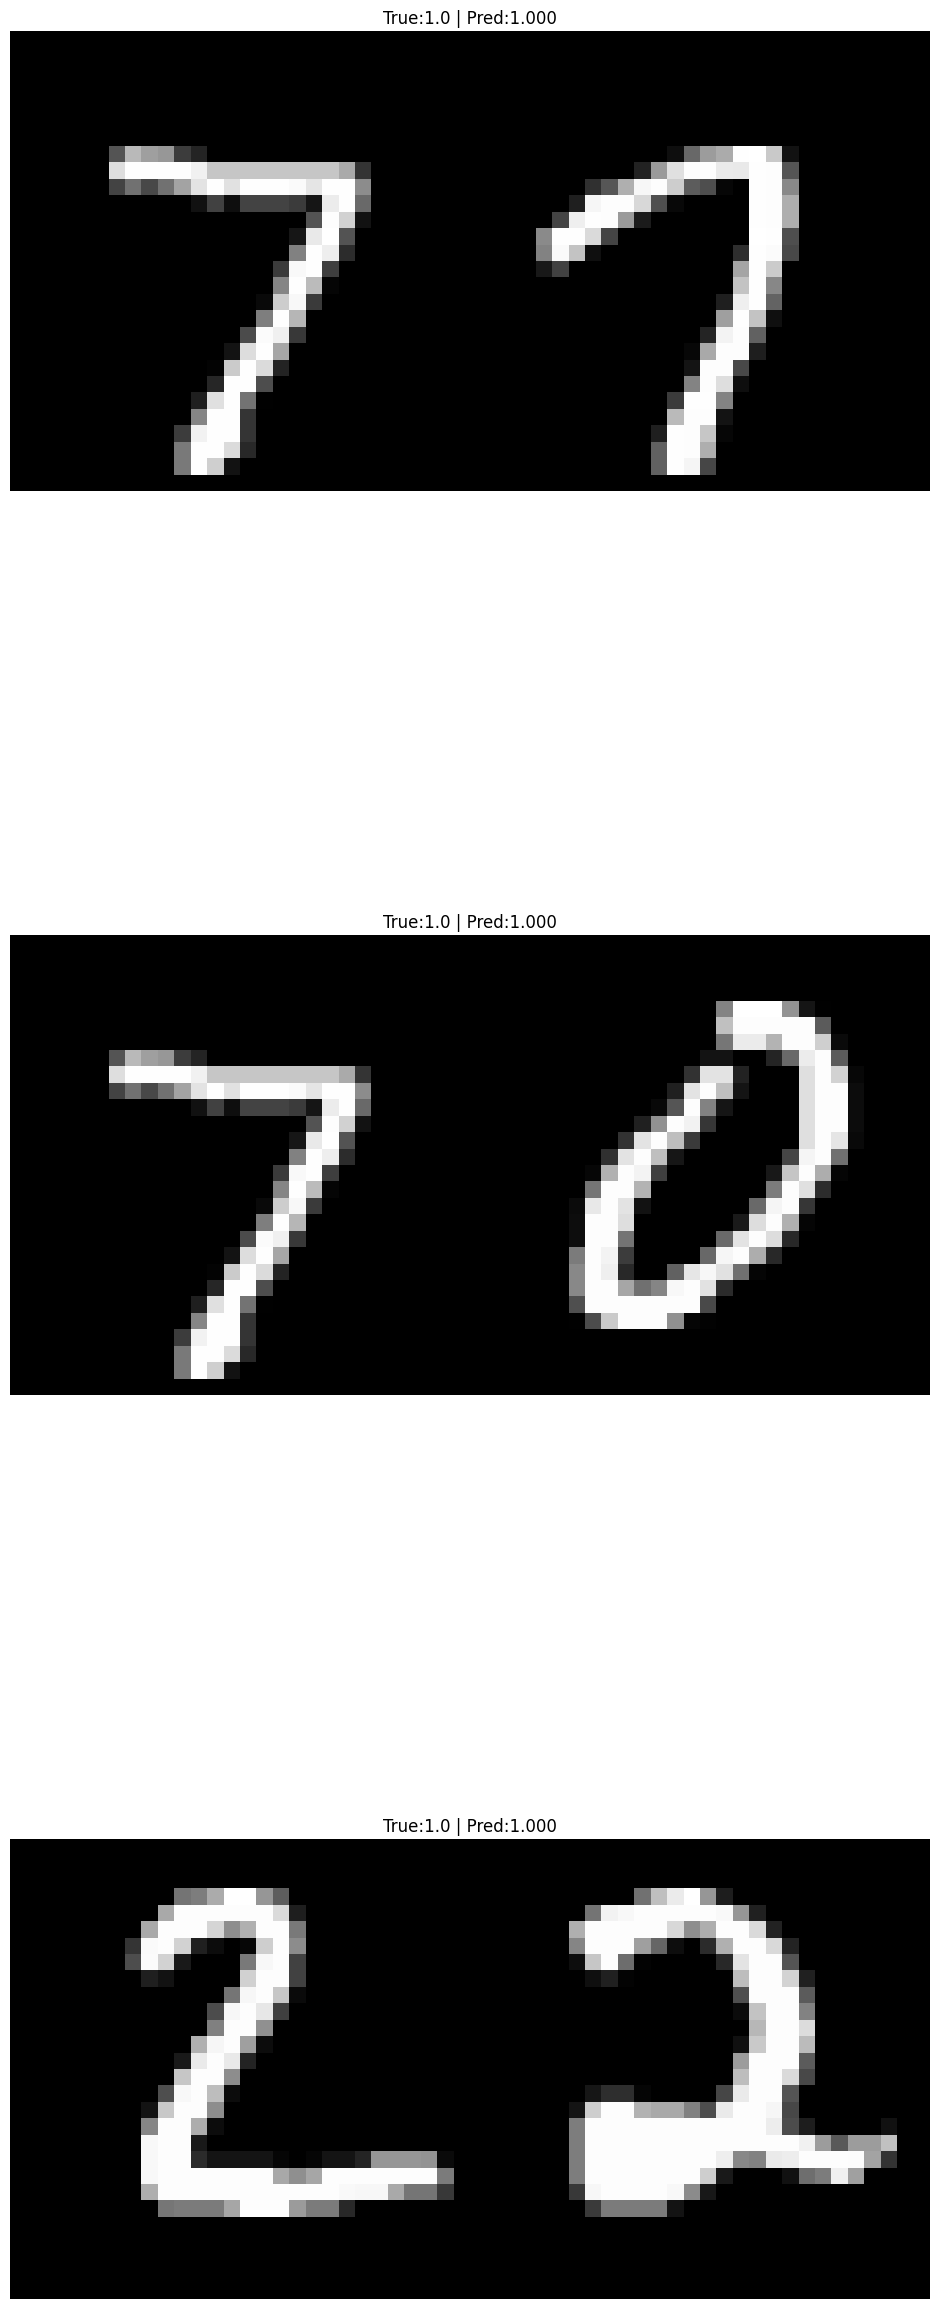

In [21]:
predictions = sisamese.predict([X_test1, X_test2])
visualize(pairs_test, labels_test, to_show =3, predictions = predictions, test = True)